### Step -1 Importing Libraries

In [3]:
import os
import pandas as pd

import spacy

nlp = spacy.load('en_core_web_sm')
import pymysql

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

parser = English()
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

!pip install sent2vec
import nltk
from sent2vec.vectorizer import Vectorizer

%pylab inline
import pandas as pd
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize



import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Populating the interactive namespace from numpy and matplotlib


### Step 2 - Establishing a connection between Python and MYSql database

In [4]:

host = os.getenv('localhost')
port = os.getenv('3306')
user = os.getenv('root')
password = os.getenv('password')
database = os.getenv('loops')

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd="password",
    db="loops",
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM ticketmaster",
    conn)


### Step 3 - Defining few Methods for cleaning the data 

In [16]:
def removePuncStr(s):
    for c in string.punctuation:
        s = s.replace(c," ")
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", s.lower()).split())

def stopText(text_array):
    stop_words = list(stopwords.words('english'))
    #+["phone","phones","iphone","iphones","apple"]
    stopped_text = []
    
    words = word_tokenize(text_array)
    h2 = ''
    for w in words:
        if w.lower() not in stop_words and len(w)>3:
            h2 = h2 + ' ' + w
    stopped_text.append(h2)
    return stopped_text[0].strip()
    
def removeNumbersStr(s):
    for c in range(10):
        n = str(c)
        s = s.replace(n," ")
    return s


In [17]:
df["clean_title"] = df["title"].apply(lambda x : (removeNumbersStr(removePuncStr(x))).strip())

In [18]:
df.head(10)

,line_num,title,createdTime,status,priority,extId,user.identity.name,user.identity.displayName,user.emailId,user.department,extId.1,integrationId,user.identity.name.1,user.identity.displayName.1,user.emailId.1,clean_title
0,0,Scan my computer now,1574305807,Closed,High,stuart.thomson@acme.com,Stuart Thomson,Stuart Thomson,stuart.thomson@acme.com,HR,gearldine_gellinger@gellinger.com,1,Gearldine,Gearldine Gellinger,gearldine_gellinger@gellinger.com,scan my computer now
1,1,how to find address book,1579538799,Closed,Low,peter.macron@acme.com,Peter Macron,Peter Macron,peter.macron@acme.com,Engineering,lnewville@newville.com,1,Lenna,Lenna Newville,lnewville@newville.com,how to find address book
2,2,Solution 2,1577330334,Closed,Medium,victoria.lewis@acme.com,Victoria Lewis,Victoria Lewis,victoria.lewis@acme.com,Legal,virgina_tegarden@tegarden.com,1,Virgina,Virgina Tegarden,virgina_tegarden@tegarden.com,solution
3,3,real time scanning wont turn on,1575271250,Closed,Low,vincent.lee@acme.com,Vincent Lee,Vincent Lee,vincent.lee@acme.com,Culture,tfrankel@aol.com,1,Tiera,Tiera Frankel,tfrankel@aol.com,real time scanning wont turn on
4,4,Refund,1588171774,Closed,Low,kim.anderson@acme.com,Kim Anderson,Kim Anderson,kim.anderson@acme.com,Product & Services,norah.waymire@gmail.com,1,Norah,Norah Waymire,norah.waymire@gmail.com,refund
5,5,800 number customer suport,1583104941,Closed,High,stuart.thomson@acme.com,Stuart Thomson,Stuart Thomson,stuart.thomson@acme.com,Engineering,trinidad_mcrae@yahoo.com,1,Trinidad,Trinidad Mcrae,trinidad_mcrae@yahoo.com,number customer suport
6,6,how to update acme,1585741284,Closed,Medium,alex.jackson@acme.com,Alex Jackson,Alex Jackson,alex.jackson@acme.com,HR,herminia@nicolozakes.org,1,Herminia,Herminia Nicolozakes,herminia@nicolozakes.org,how to update acme
7,7,how do i reset true key password,1587801893,Closed,Medium,jacob.smith@acme.com,Jacob Smith,Jacob Smith,jacob.smith@acme.com,Engineering,regenia.kannady@cox.net,1,Regenia,Regenia Kannady,regenia.kannady@cox.net,how do i reset true key password
8,8,Turn on Fire Wall?,1578503885,Closed,Low,eric.adams@acme.com,Eric Adams,Eric Adams,eric.adams@acme.com,DevOps,merlyn_lawler@hotmail.com,1,Merlyn,Merlyn Lawler,merlyn_lawler@hotmail.com,turn on fire wall
9,9,"""""You tell me I have a Trojan (after a scan th...",1577354321,Closed,Medium,".2019.@.22:47:30.464""@acme.com","2019 @ 22:47:30.464""","2019 @ 22:47:30.464""",".2019.@.22:47:30.464""@acme.com","000,false,false,Lebanon,LB,33.83333,35.83333,3...",joesph_degonia@degonia.org,1,Joesph,Joesph Degonia,joesph_degonia@degonia.org,you tell me i have a trojan after a scan three...


In [19]:
# as we are doing semantic similarity analysis, I have replaced "Need help understanding" as "how to do", 
#After a visual analysis I found that the later works better than Need help understanding"

labels = ["how to do", "Application Error", "New Feature Request", "Terminate Service"]

In [20]:
def cosine(v1, v2):
    if norm(v1) > 0 and norm(v2) > 0:
        return dot(v1, v2) / (norm(v1) * norm(v2))
    else:
        return 0.0

### Step -4 Building the Model

The basic idea is to create a label vector, which represents the 4 labels as vectors and calculate the cosine distance of each label (A) to the title vector (B).
The label with the highest similarity or is higher than a certain threshold will be assigned to the user rating.
Here as we are given the task of single label, I did not use threshold. I have given an example on how this works in the next block.
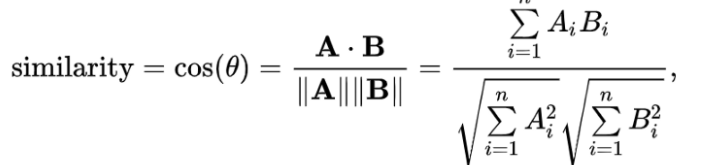

In [21]:
df_copy=df.copy()

In [18]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-MiniLM-L12-v2')

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 1.2MB 8.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-cp37-none-any.whl size=123338 sha256=6d56a93e89e1bc547525aceece57387caabe972dd99325ec2e7878504481fdbb
  Stored in directory: /root/.cache/pip/wheels/5e/89/29/45e45adc162b50f97f71801e8b07947c9cfe2b3ae7dbf37896
Successfully built sentence-transformers


You try to use a model that was created with version 1.2.0, however, your version is 1.1.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





### Step-5 Coding the approach 

In [19]:
# Usage example- In the below text block I used the same for doing the labelling for each title
#Semantic Textual Similarity
sentences1 = ['The cat sits outside',
             'A man is playing guitar',
             'The new movie is awesome']

sentences2 = ['The dog plays in the garden',
              'A woman watches TV',
              'The new movie is so great']


embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

In [20]:

#Compute cosine-similarits
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

#Output the pairs with their score
for i in range(len(sentences1)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[i], sentences2[i], cosine_scores[i][i]))

The cat sits outside 		 The dog plays in the garden 		 Score: 0.1927
A man is playing guitar 		 A woman watches TV 		 Score: 0.0188
The new movie is awesome 		 The new movie is so great 		 Score: 0.9292


In [55]:
final_list= []
for sentences in df_copy["clean_title"]:
    #print (sentences)

    
    embeddings1 = model.encode([sentences], convert_to_tensor=True)
    
    max_sim = -1 
    for label in labels : 
        
        embeddings2 = model.encode([label], convert_to_tensor=True)

        sim = util.pytorch_cos_sim(embeddings1, embeddings2)
        #print (sim,label)
        if sim > max_sim:
            max_sim = sim
            final_label = label
    final_list.append(final_label)
    #print (sentences,"|||", final_label)

df["Label"] = final_list

df["Label"].replace({"how to do":"Need Help Understanding"},inplace=True)

In [23]:
df.head()

,Unnamed: 0,line_num,title,createdTime,status,priority,extId,user.identity.name,user.identity.displayName,user.emailId,user.department,extId.1,integrationId,user.identity.name.1,user.identity.displayName.1,user.emailId.1,clean_title,Label
0,0,0,Scan my computer now,1574305807,Closed,High,stuart.thomson@acme.com,Stuart Thomson,Stuart Thomson,stuart.thomson@acme.com,HR,gearldine_gellinger@gellinger.com,1,Gearldine,Gearldine Gellinger,gearldine_gellinger@gellinger.com,scan my computer now,Need Help Understanding
1,1,1,how to find address book,1579538799,Closed,Low,peter.macron@acme.com,Peter Macron,Peter Macron,peter.macron@acme.com,Engineering,lnewville@newville.com,1,Lenna,Lenna Newville,lnewville@newville.com,how to find address book,Need Help Understanding
2,2,2,Solution 2,1577330334,Closed,Medium,victoria.lewis@acme.com,Victoria Lewis,Victoria Lewis,victoria.lewis@acme.com,Legal,virgina_tegarden@tegarden.com,1,Virgina,Virgina Tegarden,virgina_tegarden@tegarden.com,solution,Need Help Understanding
3,3,3,real time scanning wont turn on,1575271250,Closed,Low,vincent.lee@acme.com,Vincent Lee,Vincent Lee,vincent.lee@acme.com,Culture,tfrankel@aol.com,1,Tiera,Tiera Frankel,tfrankel@aol.com,real time scanning wont turn on,Need Help Understanding
4,4,4,Refund,1588171774,Closed,Low,kim.anderson@acme.com,Kim Anderson,Kim Anderson,kim.anderson@acme.com,Product & Services,norah.waymire@gmail.com,1,Norah,Norah Waymire,norah.waymire@gmail.com,refund,Terminate Service


### Step-6 Finding the Product Entities

In [11]:
import spacy 
nlp = spacy.load('en_core_web_sm')

LIST_PRODUCT = []
for text in df["title"].values:
    doc = nlp(text)
    try:
        for entity in doc.ents:
            if entity.label_=="PRODUCT":
                LIST_PRODUCT.append(entity.text)
    except:
        pass

In [13]:
list(set(LIST_PRODUCT))

['Mcaffee',
 'Acme Safe Connect',
 'Acme Media Vault',
 'Citrix',
 'CS2391904807',
 'Veroqine',
 'CS2388350555',
 'F0GrzG0BF9wAg_bpe1zF',
 'Acme  ',
 'WordPress,,Slack',
 'Windows 10',
 'Antivirus',
 'DPC3939',
 'Windows',
 'CS2428007768',
 'MVT',
 'Mcfee 10',
 'Acme one',
 'TS102268',
 'CS2421747068',
 'McAffee',
 'TS102933',
 'CS2321441319',
 'CS2431790397',
 'Acme',
 'Euro 7.82']

### Step-7 Writing the Label column back into SQL Database

In [41]:
query = "ALTER TABLE ticketmaster ADD COLUMN Label VARCHAR(500)"
vals = df.Label.tolist()

In [42]:
try: 

    with conn.cursor() as cur:

        cur.execute(query)
        cur.executemany("insert into ticketmaster(Label) values (%s)", vals )
        conn.commit()

except:
    pass
